# Metropolis-Hastings 02

#### Josep Fortiana 2018-11-28

## Exercise 2

Prepare and run a Metropolis-Hastings MCMC simulation for a simple least squares regression model.

This exercise closely follows the explanatory text and R scripts in [Florian Hartig's blog.](https://theoreticalecology.wordpress.com/2010/09/17/metropolis-hastings-mcmc-in-r/)

It is advisable to work in parallel, performing computations here and reading the blog explanations.

Warning: I switched labels `a` and `b` for intercept and slope from Hartig's notation.

#### Creating test data

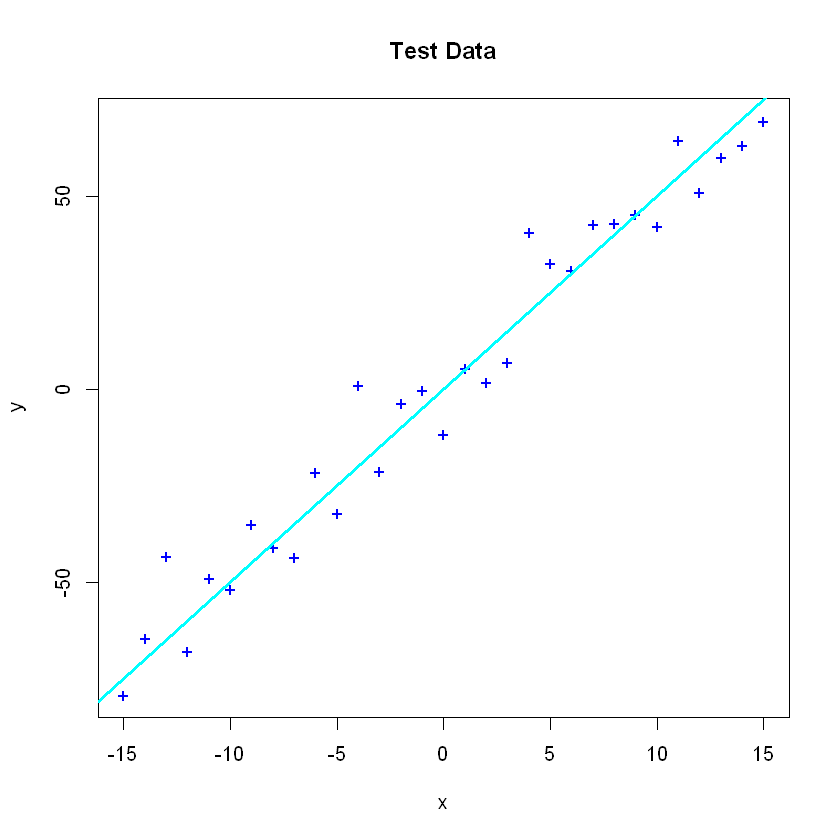

In [1]:
set.seed(24025)
trueA<-0  # R notation for abline: b is the slope
trueB<-5
trueSd<-10
sampleSize<-31
# create independent x-values 
x<-(-(sampleSize-1)/2):((sampleSize-1)/2)
# create dependent values according to a + b*x + N(0,sd)
y<-trueA+trueB*x+rnorm(n=sampleSize,mean=0,sd=trueSd)
plot(x,y,pch='+',col="blue",main="Test Data")
abline(trueA,trueB,lwd=2.5,col="cyan")

#### Adjust a classical linear model

Assuming the common standard deviation is a known constant.


Call:
lm(formula = y ~ x)

Residuals:
    Min      1Q  Median      3Q     Max 
-12.743  -7.732  -0.552   5.520  20.432 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   1.2031     1.6579   0.726    0.474    
x             4.7915     0.1854  25.851   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 9.231 on 29 degrees of freedom
Multiple R-squared:  0.9584,	Adjusted R-squared:  0.957 
F-statistic: 668.3 on 1 and 29 DF,  p-value: < 2.2e-16


,Df,Sum Sq,Mean Sq,F value,Pr(>F)
x,1,56938.147,56938.14661,668.2632,1.416233e-21
Residuals,29,2470.892,85.20318,NA,NA


[1] "Estimated intercept = 1.203000"

[1] "Estimated slope = 4.792000"

[1] "Estimated std. deviation = 9.231000"

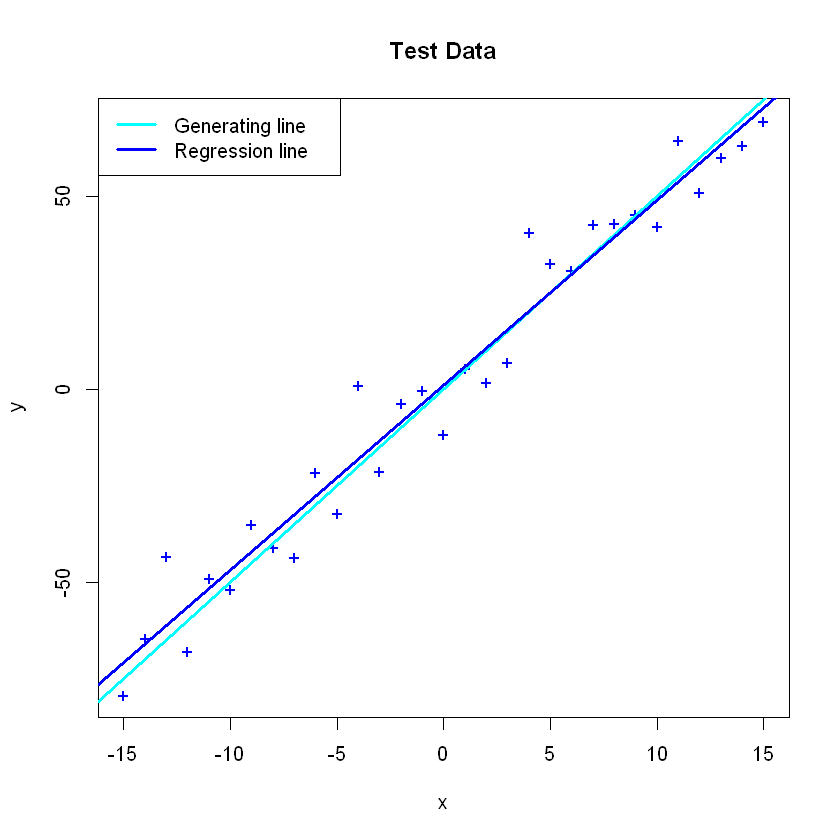

In [2]:
lm.1<-lm(y~x)
plot(x,y,pch='+',col="blue",main="Test Data")
abline(trueA,trueB,lwd=2.5,col="cyan")
abline(lm.1,lwd=2.5,col="blue")
legend("topleft",c("Generating line","Regression line"), lwd=2.5,col=c("cyan","blue"))
summary(lm.1)
a.hat<-as.numeric(lm.1$coefficients[1])
b.hat<-as.numeric(lm.1$coefficients[2])
lm.1.anova<-anova(lm.1)
lm.1.anova
# str(lm.1.anova)
sigma2.hat<-lm.1.anova$Sum[2]/lm.1.anova$Df[2]
sigma.hat<-sqrt(sigma2.hat)
sprintf("Estimated intercept = %f",round(a.hat,3))
sprintf("Estimated slope = %f",round(b.hat,3))
sprintf("Estimated std. deviation = %f",round(sigma.hat,3))

#### Log-Likelihood

We assume a normal linear model, that is, each observation $y_i\sim\operatorname{N}(a+b\cdot x_i,\sigma^2)$. 

Parameters are $a$ (intercept), $b$ (slope) and the common standard deviation $\sigma$.

In [3]:
log.likelihood <- function(param){
    a<-param[1]
    b<-param[2]
    sd<-param[3]
    pred<-a+b*x
    singleloglikelihoods = dnorm(y,mean=pred,sd=sd,log=TRUE)
    sumll<-sum(singleloglikelihoods)
    return(sumll)   
    }

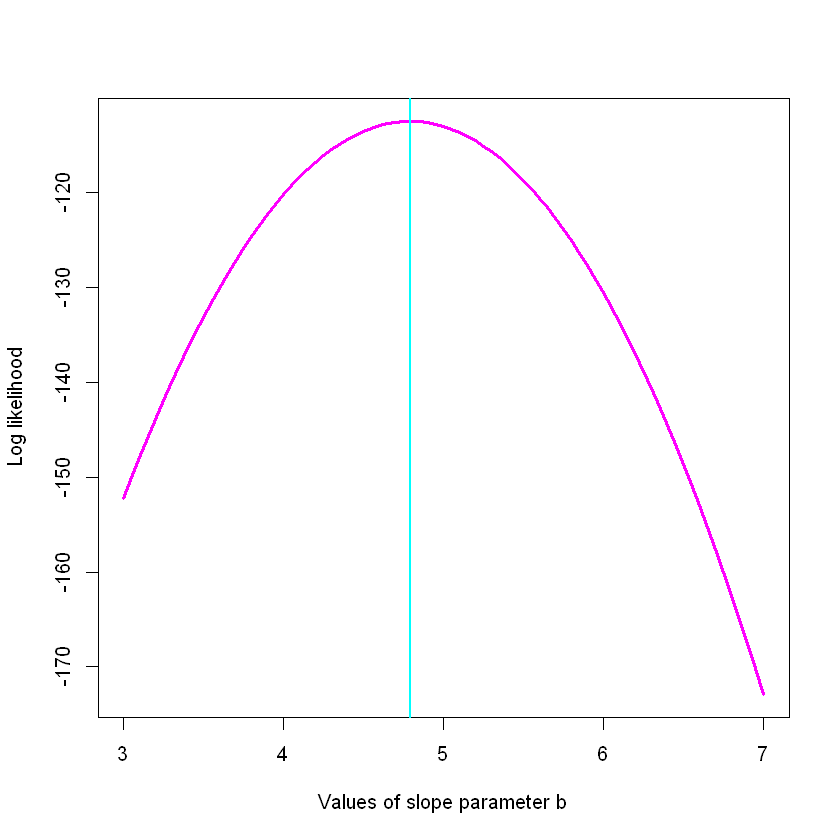

In [4]:
# Example: plot the loglikelihood profile of the slope b
slopevalues<-function(b){return(log.likelihood(c(trueA,b,trueSd)))}
slopelikelihoods<-lapply(seq(3,7,by=0.05),slopevalues)
plot(seq(3,7,by=0.05),slopelikelihoods,type="l",lwd=2.5,col="magenta",xlab="Values of slope parameter b", 
     ylab="Log likelihood")
abline(v=b.hat,col="cyan",lwd=2.0) # Max likelihood estimator of b

#### Prior

- Normal prior for the intercept, with mean=0 and sd=5.
- Uniform(0,10) for the slope.
- Uniform(0,30) for the sd parameter.

In [13]:
log.prior <- function(param){
    a<-param[1]
    b<-param[2]
    sd<-param[3]
    aprior<-dnorm(a,mean=0,sd=5,log=TRUE)
    bprior<-dunif(b,min=0,max=10,log=TRUE)
    sdprior<-dunif(sd, min=0, max=30, log = TRUE)
    return(aprior+bprior+sdprior)
    }

#### Unnormalized log-posterior

In [6]:
log.posterior <- function(param){
    return (log.likelihood(param)+log.prior(param))
    }

#### Proposal function for the Metropolis algorithm

A normal pdf for each of the three parameters.

The standard deviations should be decided by trial and error.

In [14]:
proposalfunction <- function(param){
    return(rnorm(3,mean = param, sd= c(0.1,0.1,0.3)))
    }

#### Metropolis chain generation

In [15]:
metropolis_MCMC <- function(startvalue, iterations){
    chain<-array(dim = c(iterations+1,3))
    chain[1,]<-startvalue
    for (i in 1:iterations){
        proposal<-proposalfunction(chain[i,])
        probab<-exp(log.posterior(proposal) - log.posterior(chain[i,]))
        if (runif(1)<probab)
            chain[i+1,]<-proposal
        else
            chain[i+1,]<-chain[i,]
        }
    return(chain)
    }

#### Run simulation 

- Decide chain length and `burnIn`

- Run simulation and discard first `burnIn` values

- Compute the acceptance rate

In [16]:
#ChainLength<-10000
ChainLength<-50000
startvalue<-c(0,4,10)
chain<-metropolis_MCMC(startvalue,ChainLength)
# 
#burnIn<-5000
burnIn<-10000
acceptance<-1-mean(duplicated(chain[-(1:burnIn),]))
round(acceptance,3)

[1] 0.799

#### Posterior histograms

With superimposed red vertical lines indicating "True", generating values (i.e., values originally used for generating the sample), and cyan vertical lines indicating estimated values, the LS=ML estimates obtained from the classical linear model adjustment.

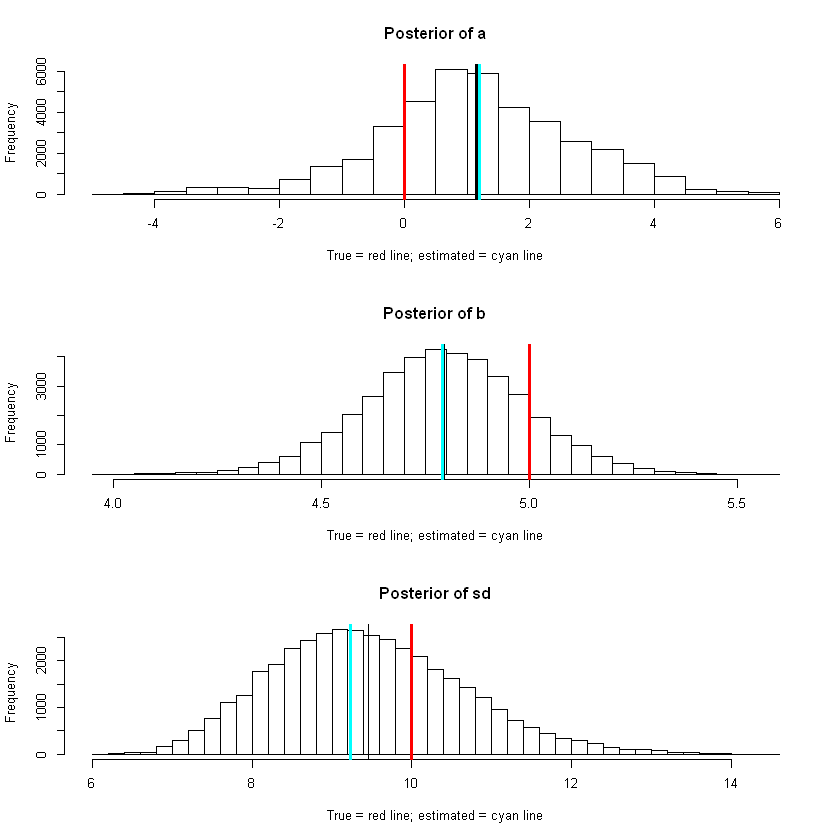

In [17]:
old.par<-par(mfrow = c(3,1))
hist(chain[-(1:burnIn),1],nclass=30, , main="Posterior of a", xlab="True = red line; estimated = cyan line")
abline(v = mean(chain[-(1:burnIn),1]),lwd=2.5)
abline(v = trueA,lwd=2.5, col="red")
abline(v=a.hat,lwd=2.5,col="cyan")
hist(chain[-(1:burnIn),2],nclass=30, main="Posterior of b", xlab="True = red line; estimated = cyan line")
abline(v = mean(chain[-(1:burnIn),2]))
abline(v = trueB,lwd=2.5, col="red")
abline(v=b.hat,lwd=2.5,col="cyan")
hist(chain[-(1:burnIn),3],nclass=30, main="Posterior of sd", xlab="True = red line; estimated = cyan line")
abline(v = mean(chain[-(1:burnIn),3]))
abline(v = trueSd,lwd=2.5, col="red" )
abline(v = sigma.hat,lwd=2.5, col="cyan")
par(old.par)

#### Traceplot

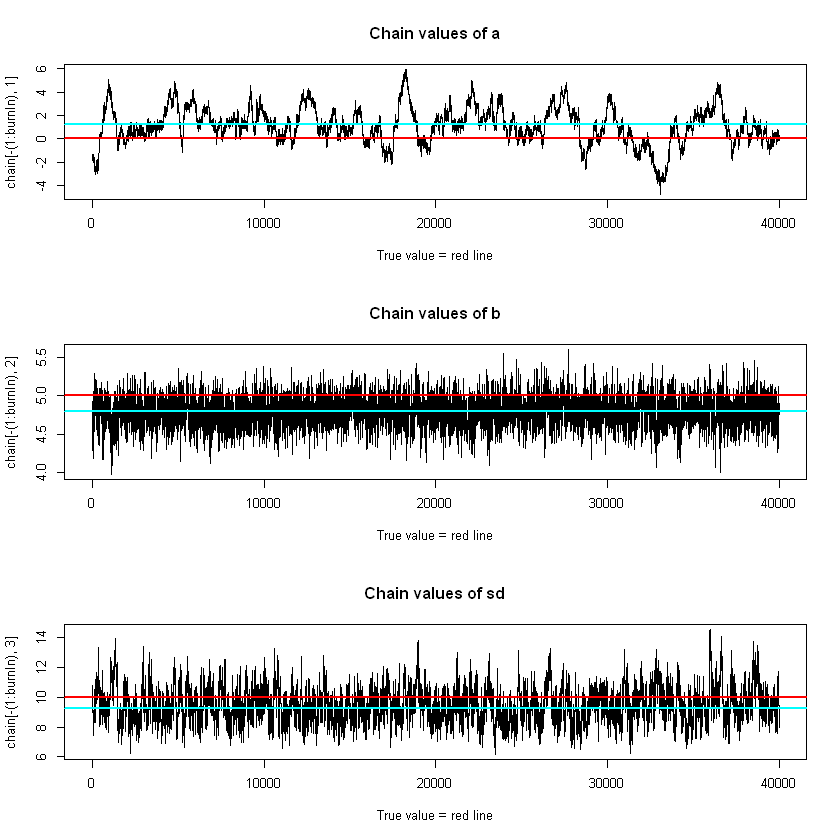

In [18]:
old.par<-par(mfrow = c(3,1))
plot(chain[-(1:burnIn),1], type = "l", xlab="True value = red line" , main = "Chain values of a", )
abline(h=trueA,lwd=2.0,col="red")
abline(h=a.hat,lwd=2.0,col="cyan")
plot(chain[-(1:burnIn),2], type = "l", xlab="True value = red line" , main = "Chain values of b", )
abline(h=trueB,lwd=2.0,col="red")
abline(h=b.hat,lwd=2.0,col="cyan")
plot(chain[-(1:burnIn),3], type = "l", xlab="True value = red line" , main = "Chain values of sd", )
abline(h=trueSd,lwd=2.0,col="red")
abline(h=sigma.hat,lwd=2.0,col="cyan")
par(old.par) 

In [33]:
require(R2jags)
simple.regression.m0.mcmc<-as.mcmc(chain[-(1:burnIn),])
dimnames(simple.regression.m0.mcmc)<-list(NULL,c("a","b","sigma"))

Loading required package: R2jags
Warning message:
"package 'R2jags' was built under R version 3.4.4"Error: package or namespace load failed for 'R2jags' in loadNamespace(j <- i[[1L]], c(lib.loc, .libPaths()), versionCheck = vI[[j]]):
 there is no package called 'boot'


In [34]:
acfplot

function (x, data, ...) 
UseMethod("acfplot")
<environment: namespace:coda>

In [35]:
str(simple.regression.m0.mcmc)

 mcmc [1:40001, 1:3] -1.64 -1.64 -1.64 -1.79 -1.79 ...
 - attr(*, "mcpar")= num [1:3] 1 40001 1
 - attr(*, "dimnames")=List of 2
  ..$ : NULL
  ..$ : chr [1:3] "a" "b" "sigma"


In [36]:
summary(simple.regression.m0.mcmc)


Iterations = 1:40001
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 40001 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

       Mean     SD  Naive SE Time-series SE
a     1.151 1.5531 0.0077655       0.266587
b     4.795 0.1937 0.0009685       0.004573
sigma 9.454 1.1948 0.0059739       0.056886

2. Quantiles for each variable:

        2.5%    25%   50%    75%  97.5%
a     -2.274 0.2187 1.107  2.158  4.144
b      4.407 4.6696 4.796  4.924  5.175
sigma  7.389 8.5918 9.365 10.224 12.052


## JAGS implementation

In [37]:
install.packages("R2jags", repos= "https://cloud.r-project.org")
require(R2jags)

package 'R2jags' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\ASUS\AppData\Local\Temp\Rtmpqaj0Fv\downloaded_packages


Loading required package: R2jags
Warning message:
"package 'R2jags' was built under R version 3.4.4"Error: package or namespace load failed for 'R2jags' in loadNamespace(j <- i[[1L]], c(lib.loc, .libPaths()), versionCheck = vI[[j]]):
 there is no package called 'boot'


In [39]:
# tau is the common precision parameter = 1/ sigma^2  for all 
# prior for a has sd=5, that is, precision 1/5^2 = 0.04
# Likelihood, for each observation 
# Priors: normal priors for a, uniform for b and sigma, as above:
N<-sampleSize
cat("model {for (i in 1:N){ 
                y[i] ~ dnorm(y.hat[i], tau) 
                y.hat[i] <- a + b * x[i] 
                }

            a ~ dnorm(0,0.04) 
            b ~ dunif(0,10) 
            tau <- pow(sigma, -2) 
            sigma ~ dunif(0,30)  
            } ",file="simple.regression.jag")
simple.regression.dat <- list("x" = x, "y" = y, "N" = N)

In [40]:
simple.regression.m1<-jags(data=simple.regression.dat, n.chains=3,
        parameters.to.save=c("a", "b","sigma"), 
        model.file="simple.regression.jag",n.iter=10000,n.burnin=2000)

ERROR: Error in jags(data = simple.regression.dat, n.chains = 3, parameters.to.save = c("a", : could not find function "jags"


In [41]:
plot(simple.regression.m1)

ERROR: Error in plot(simple.regression.m1): object 'simple.regression.m1' not found


In [26]:
traceplot(simple.regression.m1)

ERROR: Error in mcmc.list(x): object 'simple.regression.m1' not found


In [27]:
simple.regression.m1.mcmc<-as.mcmc(simple.regression.m1)

ERROR: Error in as.mcmc(simple.regression.m1): object 'simple.regression.m1' not found


In [28]:
summary(simple.regression.m1.mcmc)

ERROR: Error in summary(simple.regression.m1.mcmc): object 'simple.regression.m1.mcmc' not found


In [29]:
str(simple.regression.m1.mcmc)

ERROR: Error in str(simple.regression.m1.mcmc): object 'simple.regression.m1.mcmc' not found


In [45]:
require(lattice)

Loading required package: lattice


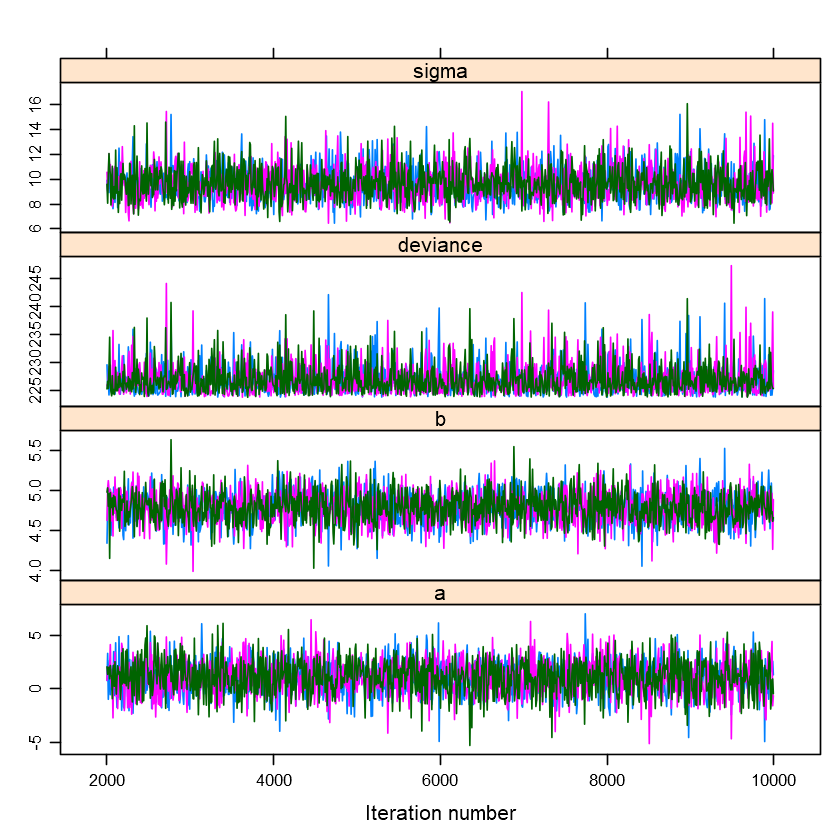

In [47]:
xyplot(simple.regression.m1.mcmc)

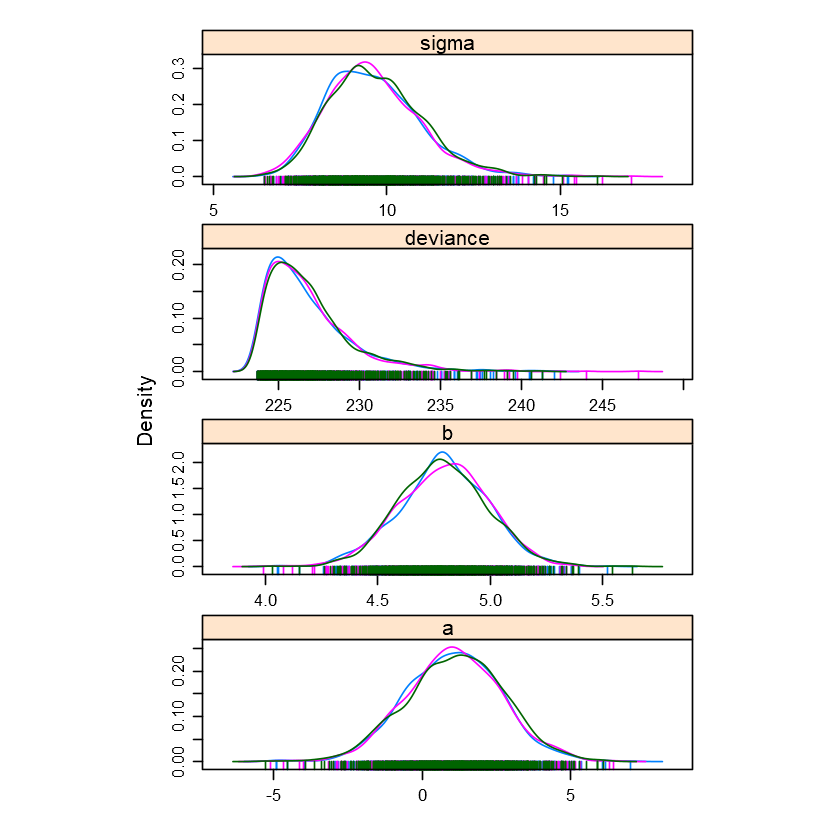

In [48]:
densityplot(simple.regression.m1.mcmc)

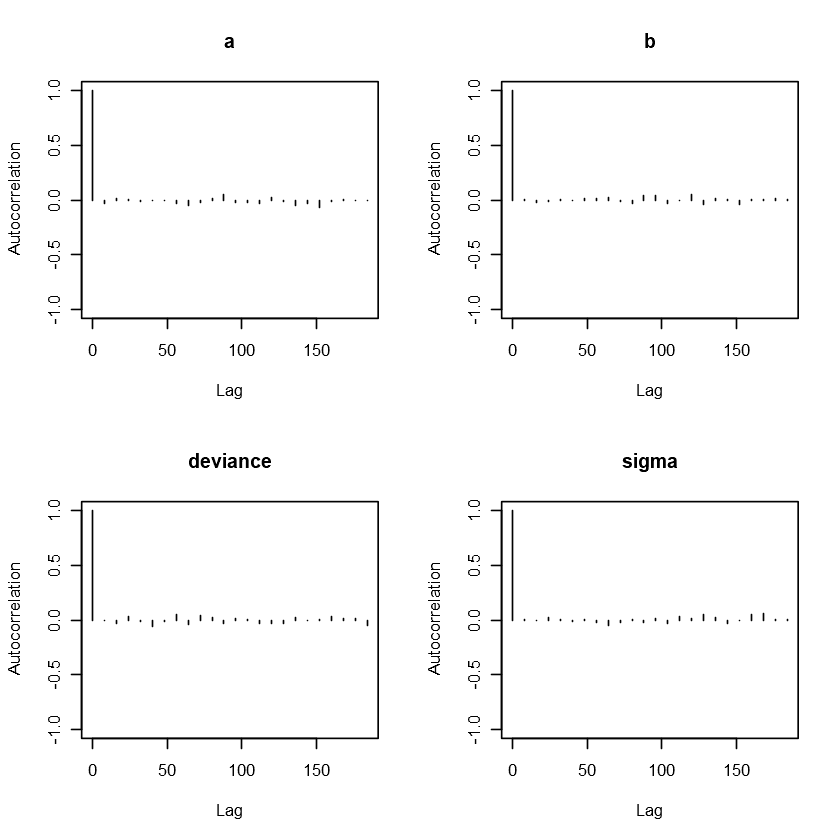

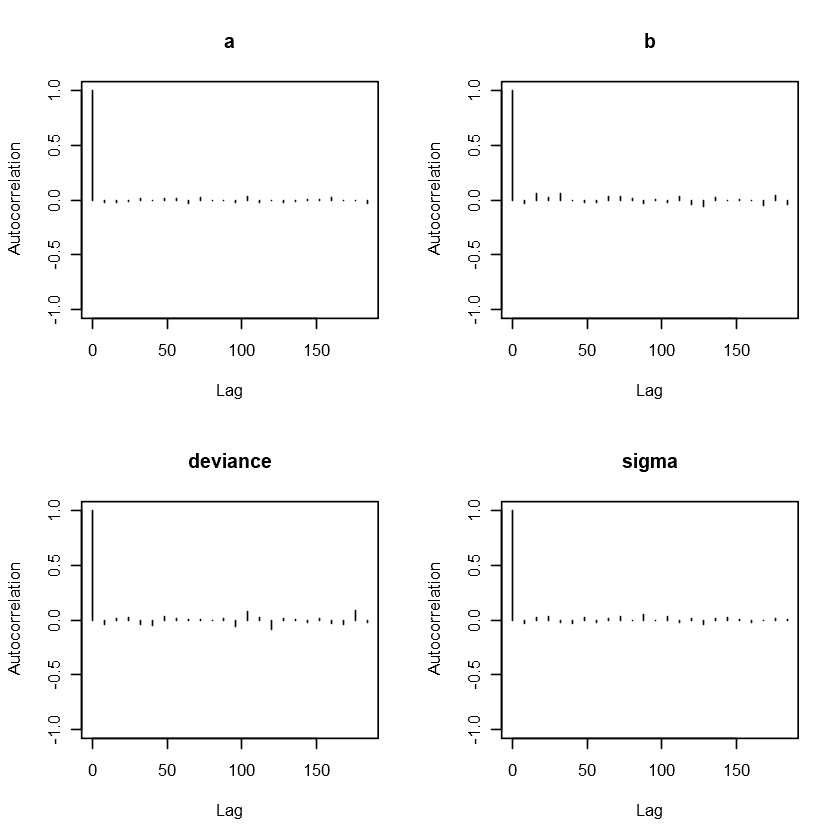

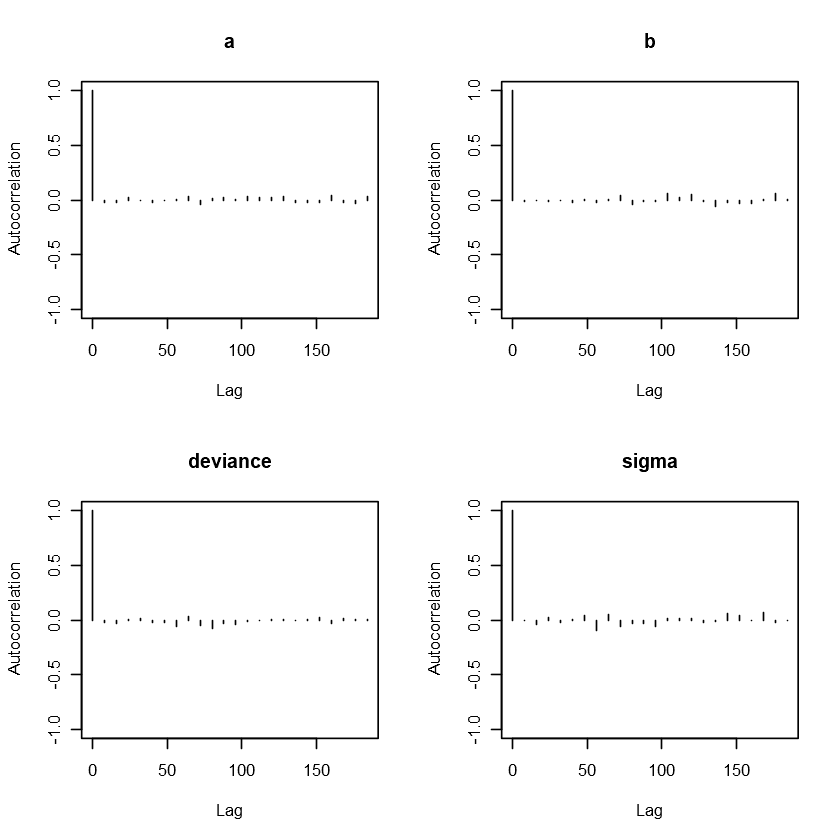

In [49]:
autocorr.plot(simple.regression.m1.mcmc)

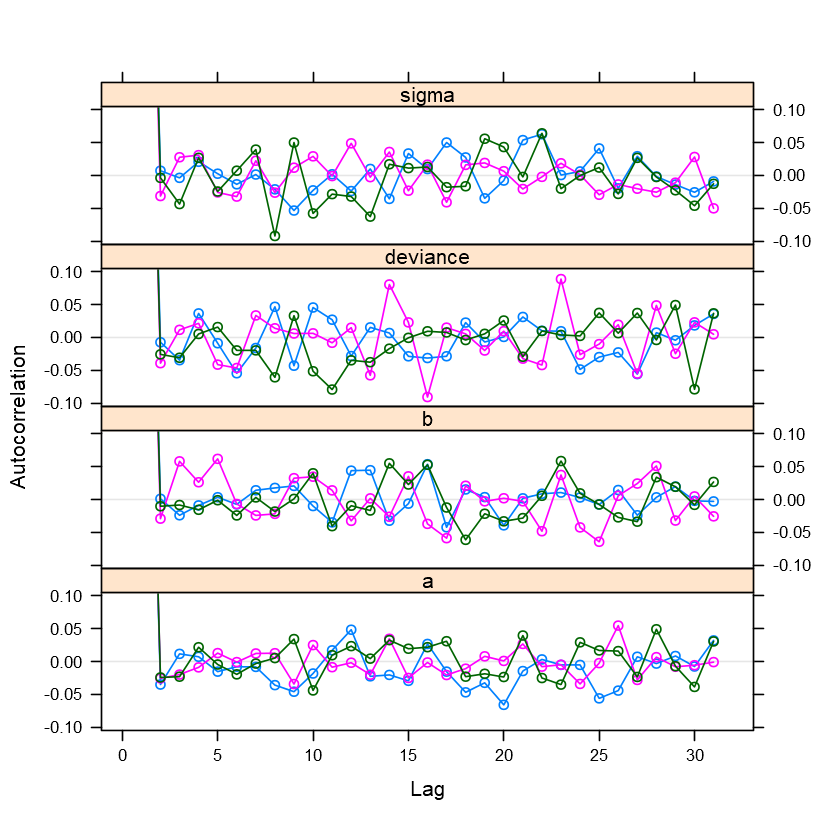

In [50]:
acfplot(simple.regression.m1.mcmc)